# FIT (Fast Import Tool)

The FIT imports appropriate data from NCBI GEO.  This program is written in R.

The Gene Expression Omnibus (GEO) from NCBI is a public repository for genetic based experimental data. The data is mostly microarray-based results, typically measuring mRNA, genomic DNA, and protein data. At the most basic level of organization of GEO, there are three entity types that may be supplied by users: Platforms, Samples, and Series. Additionally, there is a curated entity called a GEO dataset.

A Platform record describes the list of elements on the array (e.g., cDNAs, oligonucleotide probesets, ORFs, antibodies) or the list of elements that may be detected and quantified in that experiment (e.g., SAGE tags, peptides). Each Platform record is assigned a unique and stable GEO accession number (GPLxxx). A Platform may reference many Samples that have been submitted by multiple submitters.

A Sample record describes the conditions under which an individual Sample was handled, the manipulations it underwent, and the abundance measurement of each element derived from it. Each Sample record is assigned a unique and stable GEO accession number (GSMxxx). A Sample entity must reference only one Platform and may be included in multiple Series. A Series record defines a set of related Samples considered to be part of a group, how the Samples are related, and if and how they are ordered. A Series provides a focal point and description of the experiment as a whole. Series records may also contain tables describing extracted data, summary conclusions, or analyses. Each Series record is assigned a unique and stable GEO accession number (GSExxx).

GEO DataSets (GDSxxx) are curated sets of GEO Sample data. A GDS record represents a collection of biologically and statistically comparable GEO Samples and forms the basis of GEO's suite of data display and analysis tools. Samples within a GDS refer to the same Platform, that is, they share a common set of probe elements. Value measurements for each Sample within a GDS are assumed to be calculated in an equivalent manner, that is, considerations such as background processing and normalization are consistent across the dataset. Information reflecting experimental design is provided through GDS subsets.

GeneChip RMA (GC-RMA) is an improved form of RMA that is able to use the sequence-specific probe affinities of the GeneChip probes to attain more accurate gene expression values.

**Enter the series for import:**

https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE27562

Must be all upper case.

In [1]:
series = "GSE27562"

### Libraries used

To install libraries, from R console use:
```R
install.packages("ggplot2")
```

For Bioconductor packages first get biocLite via
```R
source("https://bioconductor.org/biocLite.R")
```
Then install packages. Example:
```R
biocLite("GEOquery")
```

In [50]:
library(biocLite)
library(GEOquery)
library(affy)
library(gcrma)
library(RColorBrewer)
library(affyPLM)
library(simpleaffy)

ERROR: Error in library(biocLite): there is no package called ‘biocLite’


### Get/Create directories

Assumes this notebook is in notebook folder.

In [3]:
notebook_dir <- getwd()
main_dir <- dirname(notebook_dir)
gse_dir = file.path(main_dir,"gseRaw")
if (!dir.exists(gse_dir)) {
    dir.create(gse_dir)
}

### Load GEO data

Specifically we are interested in only GSE Data.

The function returns a list because you might be getting multiple SubSeries.

http://legacydirs.umiacs.umd.edu/~hcorrada/CFG/lectures/lect21_bioc/bioconductor.pdf

In [42]:
gse <- getGEO(GEO = series, destdir = gse_dir)
if(length(gse)>1) {
    print("WARNING: multiple SubSeries.")
}
show(gse)

Found 1 file(s)
GSE27562_series_matrix.txt.gz
Using locally cached version: /Users/terek/Documents/Github/GenClass-Stability/gseRaw/GSE27562_series_matrix.txt.gz
Parsed with column specification:
cols(
  .default = col_double(),
  ID_REF = col_character()
)
See spec(...) for full column specifications.
Using locally cached version of GPL570 found here:
/Users/terek/Documents/Github/GenClass-Stability/gseRaw/GPL570.soft 


$GSE27562_series_matrix.txt.gz
ExpressionSet (storageMode: lockedEnvironment)
assayData: 54675 features, 162 samples 
  element names: exprs 
protocolData: none
phenoData
  sampleNames: GSM681982 GSM681983 ... GSM682143 (162 total)
  varLabels: title geo_accession ... tissue:ch1 (40 total)
  varMetadata: labelDescription
featureData
  featureNames: 1007_s_at 1053_at ... AFFX-TrpnX-M_at (54675 total)
  fvarLabels: ID GB_ACC ... Gene Ontology Molecular Function (16 total)
  fvarMetadata: Column Description labelDescription
experimentData: use 'experimentData(object)'
Annotation: GPL570 



In [5]:
pheno <- phenoData(gse[[1]]) #ref gse meta for phenotype
feat <- featureData(gse[[1]]) #ref gse meta for features

In [51]:
pheno

An object of class 'AnnotatedDataFrame'
  sampleNames: GSM681982 GSM681983 ... GSM682143 (162 total)
  varLabels: title geo_accession ... tissue:ch1 (40 total)
  varMetadata: labelDescription

In [37]:
feat

An object of class 'AnnotatedDataFrame'
  featureNames: 1007_s_at 1053_at ... AFFX-TrpnX-M_at (54675 total)
  varLabels: ID GB_ACC ... Gene Ontology Molecular Function (16 total)
  varMetadata: Column Description labelDescription

### Download Supplementary Files

Get the raw expression data for the samples. getGEOSuppFiles doesn't check if the files already exist, so we perform a check.

In [8]:
if (!dir.exists(file.path(gse_dir, series))) {
    suppFiles = getGEOSuppFiles(GEO = series, makeDirectory = TRUE, baseDir = gse_dir)
    tarFiles = file.path(rownames(suppFiles)[1])
    untarPath = file.path(dirname(tarFiles),"data")
    if (!dir.exists(file.path(untarPath))) {
        untar(tarFiles, exdir=untarPath)
    }
}

In [9]:
setwd(file.path(gse_dir,series,"data")) # TODO: convert series to upper case.
celfiles.data = ReadAffy()

In [45]:
celfiles.data

AffyBatch object
size of arrays=1164x1164 features (89 kb)
cdf=HG-U133_Plus_2 (54675 affyids)
number of samples=162
number of genes=54675
annotation=hgu133plus2
notes=

In [48]:
probe_name = annotation(celfiles.data)

In [53]:
lib <- paste(probe_name, ".db", sep = "")
source("https://bioconductor.org/biocLite.R")
biocLite(lib)
library(lib, character.only=TRUE)

Bioconductor version 3.7 (BiocInstaller 1.30.0), ?biocLite for help
BioC_mirror: https://bioconductor.org
Using Bioconductor 3.7 (BiocInstaller 1.30.0), R 3.5.1 (2018-07-02).
Installing package(s) ‘hgu133plus2.db’
Old packages: 'fansi'


In [10]:
#celfiles.gcrma <- gcrma(celfiles.data)
#celfiles.mas5 <- mas5(celfiles.data)
celfiles.rma <- rma(celfiles.data)

Warning message:
“replacing previous import ‘AnnotationDbi::tail’ by ‘utils::tail’ when loading ‘hgu133plus2cdf’”Warning message:
“replacing previous import ‘AnnotationDbi::head’ by ‘utils::head’ when loading ‘hgu133plus2cdf’”


Background correcting
Normalizing
Calculating Expression


In [12]:
cols <- brewer.pal(8, "Set1")

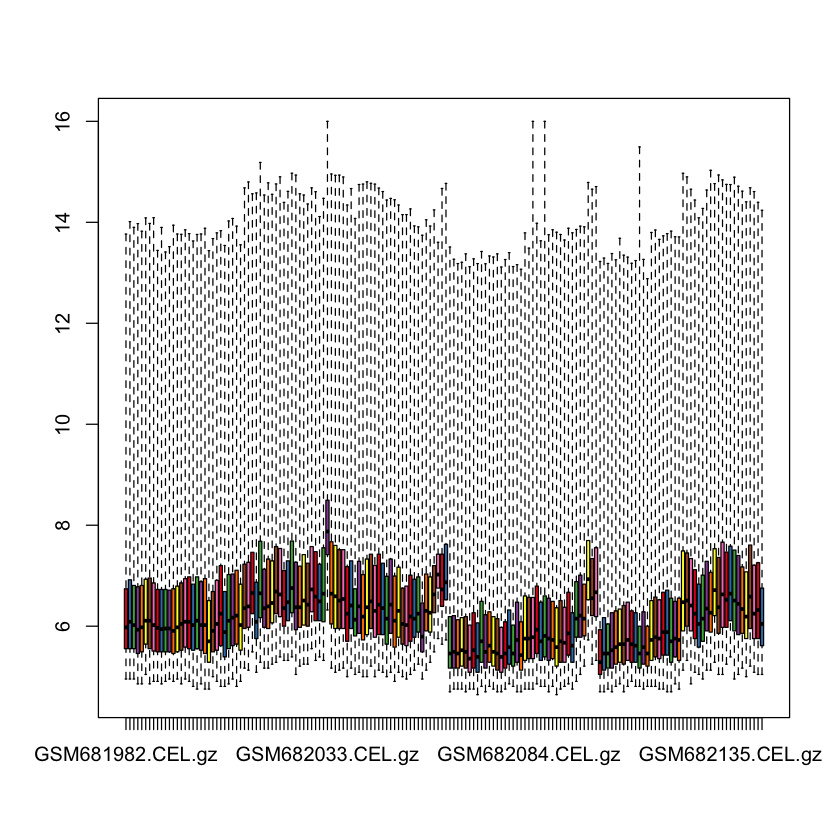

In [15]:
# plot a boxplot of unnormalised intensity values
# uncomment to save as eps postcript file
#setEPS()
#postscript(paste(series, "_bp_data.eps", sep = ""))
boxplot(celfiles.data, col=cols)
#dev.off()

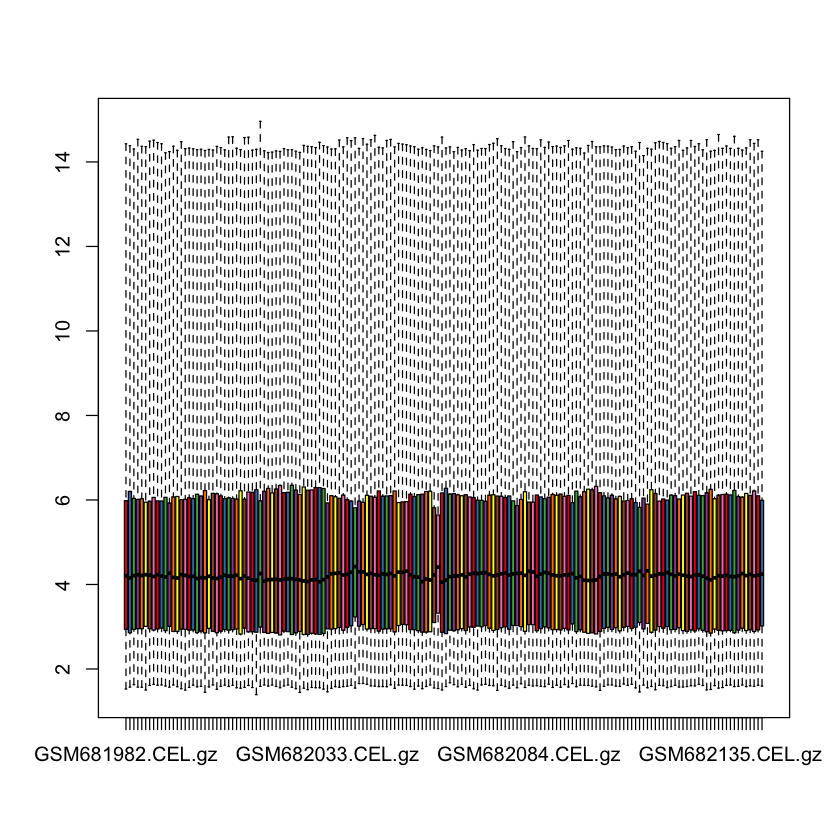

In [16]:
#setEPS()
#postscript(paste(series, "_bp_rma.eps", sep = ""))
boxplot(celfiles.rma, col=cols)
#dev.off()

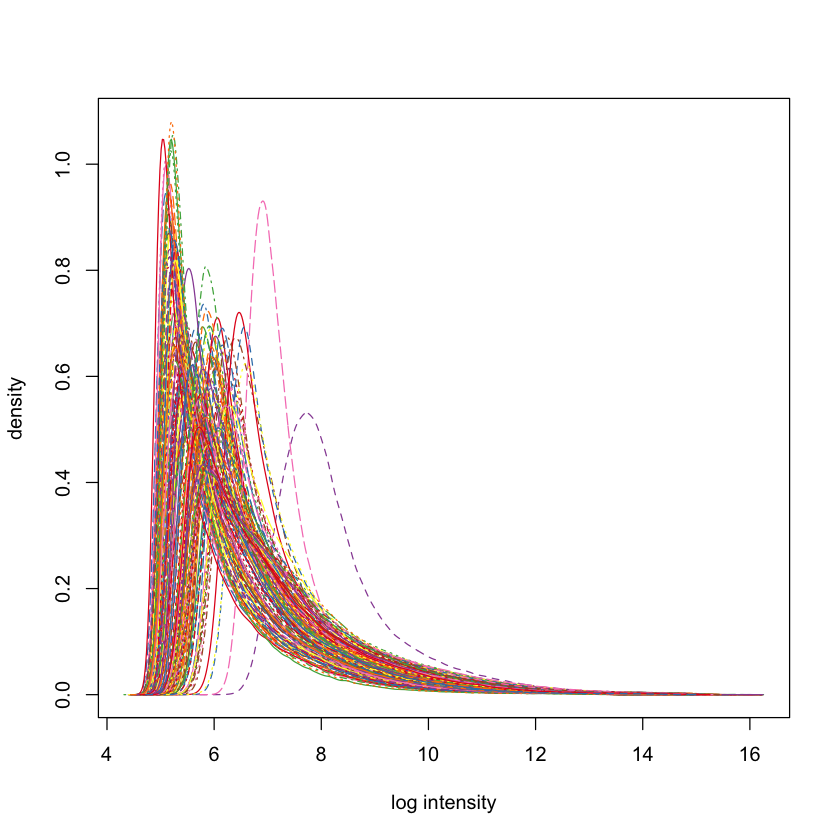

In [17]:
#setEPS()
#postscript(paste(series, "_hist_data.eps", sep = ""))
hist(celfiles.data, col=cols)
#dev.off()

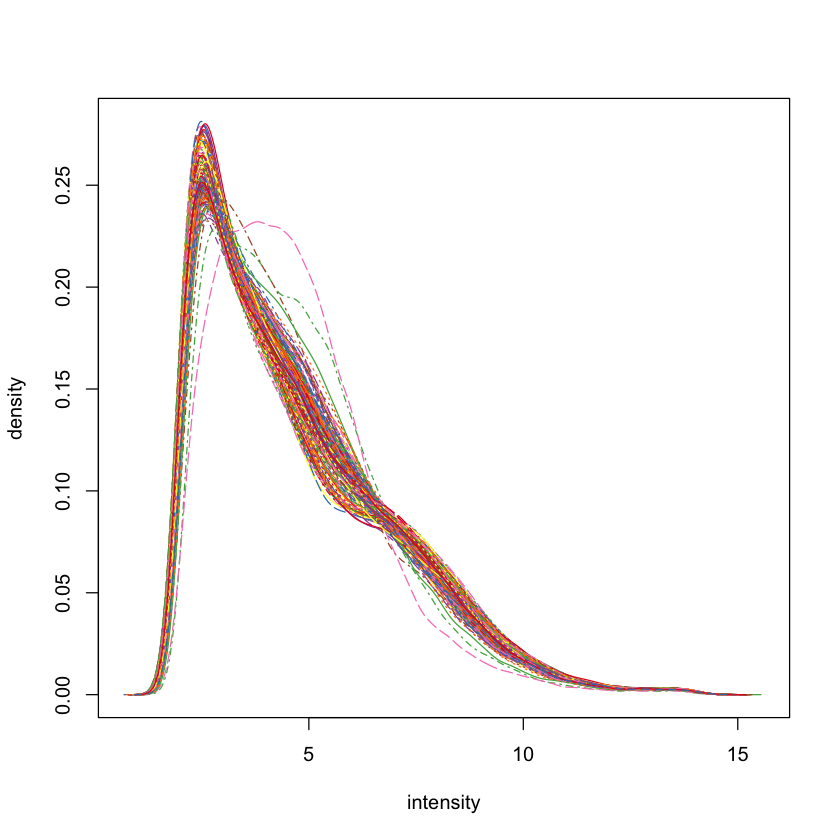

In [18]:
#setEPS()
#postscript(paste(series, "_hist_rma.eps", sep = ""))
hist(celfiles.rma, col=cols)
#dev.off()

In [19]:
celfiles.qc <- fitPLM(celfiles.data)

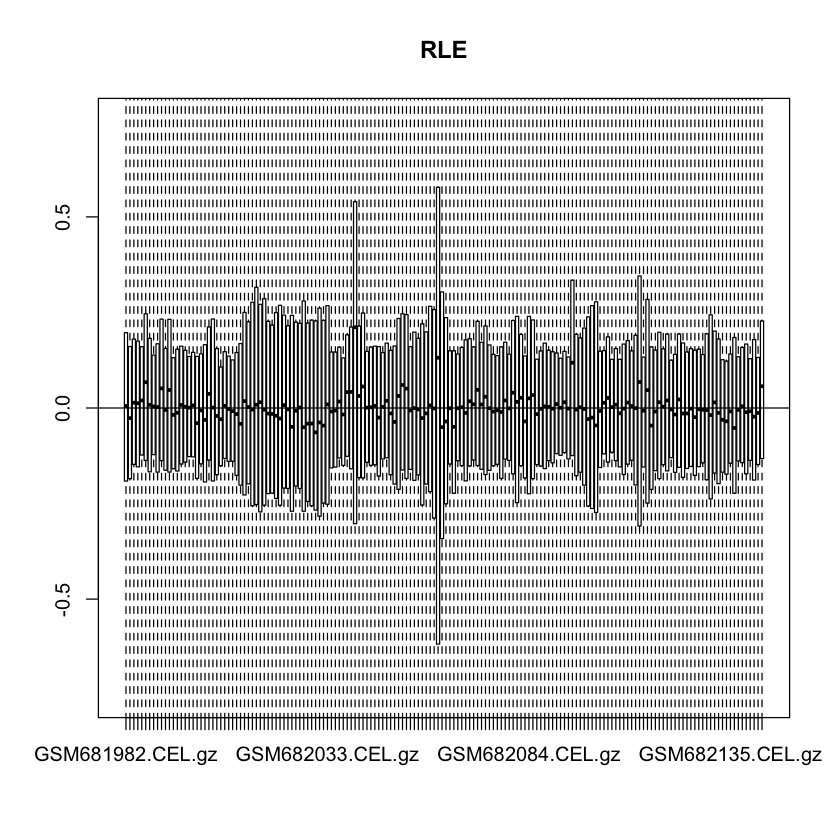

In [20]:
#setEPS()
#postscript(paste(series, "_RLE_data.eps", sep = ""))
RLE(celfiles.qc, main="RLE")

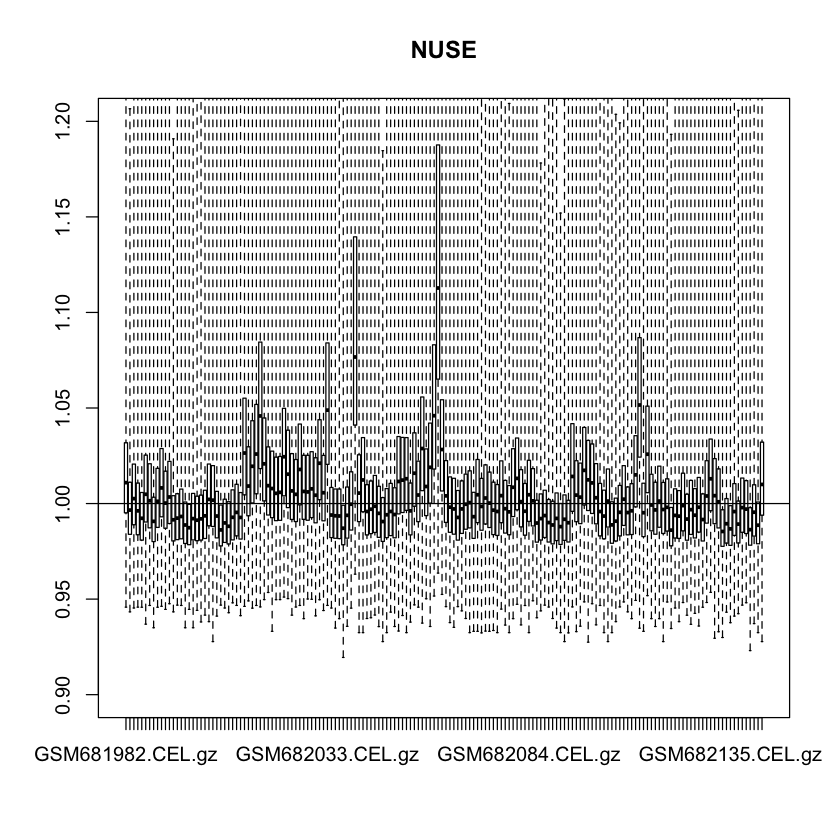

In [21]:
NUSE(celfiles.qc, main="NUSE")

In [22]:
eset.rma <- exprs(celfiles.rma)

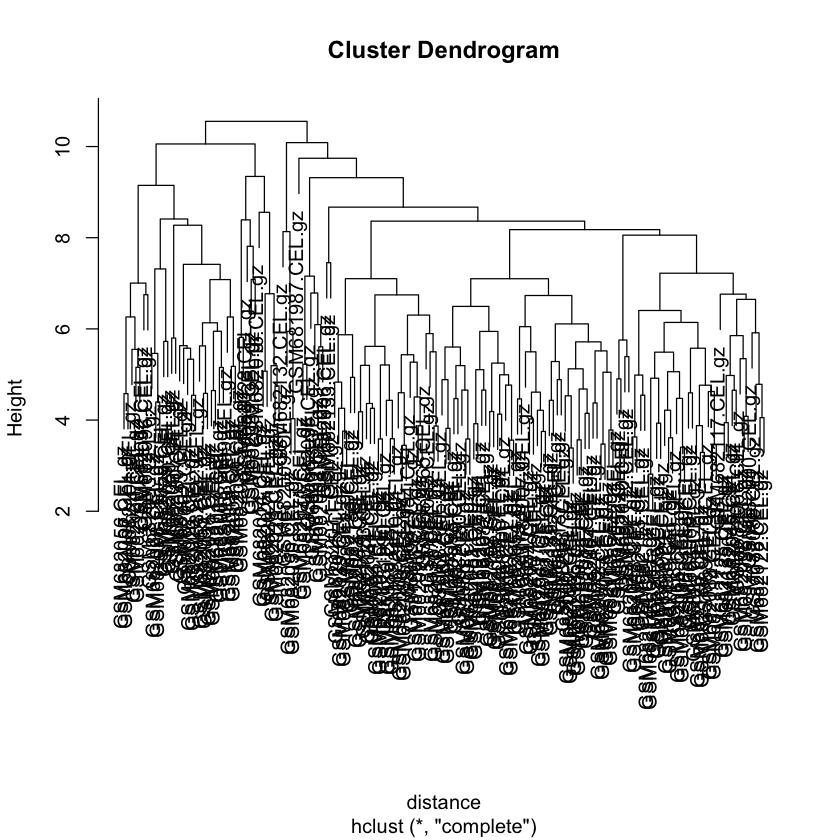

In [54]:
celfiles.filtered_rma <- nsFilter(celfiles.rma, require.entrez=TRUE, remove.dupEntrez=TRUE)

In [55]:
celfiles.filtered_rma

$eset
ExpressionSet (storageMode: lockedEnvironment)
assayData: 10094 features, 162 samples 
  element names: exprs 
protocolData
  sampleNames: GSM681982.CEL.gz GSM681983.CEL.gz ... GSM682143.CEL.gz
    (162 total)
  varLabels: ScanDate
  varMetadata: labelDescription
phenoData
  sampleNames: GSM681982.CEL.gz GSM681983.CEL.gz ... GSM682143.CEL.gz
    (162 total)
  varLabels: sample
  varMetadata: labelDescription
featureData: none
experimentData: use 'experimentData(object)'
Annotation: hgu133plus2 

$filter.log
$filter.log$numDupsRemoved
[1] 21739

$filter.log$numLowVar
[1] 10094

$filter.log$numRemoved.ENTREZID
[1] 12738

$filter.log$feature.exclude
[1] 10



In [56]:
celfiles.rma

ExpressionSet (storageMode: lockedEnvironment)
assayData: 54675 features, 162 samples 
  element names: exprs 
protocolData
  sampleNames: GSM681982.CEL.gz GSM681983.CEL.gz ... GSM682143.CEL.gz
    (162 total)
  varLabels: ScanDate
  varMetadata: labelDescription
phenoData
  sampleNames: GSM681982.CEL.gz GSM681983.CEL.gz ... GSM682143.CEL.gz
    (162 total)
  varLabels: sample
  varMetadata: labelDescription
featureData: none
experimentData: use 'experimentData(object)'
Annotation: hgu133plus2 

In [57]:
celfiles.data

AffyBatch object
size of arrays=1164x1164 features (89 kb)
cdf=HG-U133_Plus_2 (54675 affyids)
number of samples=162
number of genes=54675
annotation=hgu133plus2
notes=

In [61]:
rma_mat <- exprs(celfiles.filtered_rma[[1]])

In [63]:
length(rma_mat)

[1] 1635228